<img src="https://geodecode.com.br/wp-content/uploads/2021/12/brasildatacube.png" align="left" width="74"/>
<img src="https://brazil-data-cube.github.io/_images/logo-odc-bdc.png" align="right" width="74" />

<h1 style="color:#336699; text-align: center" >Annual Metting Use Case</h1>
<hr style="border:2px solid #0077b9;">

<br/>

<div style="text-align: center;font-size: 90%;">
    <sup>
        <a href="https://orcid.org/0000-0002-9916-1167">
            <i class="fab fa-lg fa-orcid" style="color: #a6ce39"></i>
        </a>
    </sup>
    <br/>
    Brazil Data Cube (BDC), National Institute for Space Research (INPE)
    <br/>
    <br/>
    <br/>
    <div style="width: 98%;">
        <div style="text-align: justify; border-style: solid; border-color: #0077b9; border-width: 1px; padding: 10px;">
            <b>Explantion here....:</b>
            <div>
                Write write write write writewrite writewrite write. <a href="http://www.brazildatacube.org/" target="_blank">Site site site site site</a>, <i> Outras infos</i> .......
            </div>
        </div>
    </div>
</div>

In [1]:
# from_freatures_to_hrefs_per_months <- function(features, band){
#     images <- list()
#     for (i in 1:length(features)) {
#         feature <- features[[i]]
#         # Get month
#         date <- feature$properties$datetime
#         month <- substr(date, 6, 7)
#         # Get href
#         # href <- feature['assets.NDVI.href']
#         href <- feature$assets[[band]]$href
#         # If data list doesn't have hrefs for this month, create this sublist
#         if (is.null(images[[month]])) {
#             images[[month]] <- list()
#         }
#         # Set month sublist
#         images[[month]] <- c(images[[month]], href)
#     }
#     return(images)
# }

In [52]:
# library(terra)
library(sf)
# library(httr)
# library(jsonlite)
library(raster)
library(rstac)
# library(geojsonsf)
# library(sfheaders)
library(sits)
library(gdalcubes)
library(tmap)
library(dplyr)
library(ggplot2)

# List Harmonize STAC Collections and BDC SITS collections
<hr style="border:1px solid #0077b9;">

In [ ]:
HARMONIZE_STAC_URL <- 'https://brazildatacube.dpi.inpe.br/harmonize/dev/stac/v1/'

stac_data <- GET(paste0(HARMONIZE_STAC_URL, "/collections")) %>%
  content(., "text") %>%
  fromJSON(flatten = TRUE)
  
ids <- stac_data$collections$id %>% sort()
ids


sits_list_collections(source = "BDC")

# Constants and ROI
<hr style="border:1px solid #0077b9;">

In [119]:
# ===================================
# FOLDERS PATHS AND PARALLEL SETTINGS
ORIGINAL_IMAGES_FOLDER <- "tifs"
MONTHLY_IMAGES_FOLDER <- "month"
MOSAIC_IMAGES_FOLDER <- "mosaic"
MULTICORES <- 3L

# ================
# SEARCH VARIABLES
# START_DATE <- "2019-07-01"
# END_DATE <- "2019-08-01"
START_DATE <- "2019-01-01"
END_DATE <- "2021-12-31"
COLLECTION <- "SENTINEL-2-16D"

# =============================
# ROI and ROI related variables
TEMPERATURE_COLLECTION_ID <- "max_temper_mean_no_mun_month-1"
DENGUE_COLLECTION_ID <- "dengue_cases_mun_month_north-1"

shape_st <- st_read("roi/mun_indireto_PA.shp")
shape_df <- data.frame(shape_st)
bbox <- st_bbox(shape_st)
bbox
dim(shape_df)
head(shape_df)

Reading layer `mun_indireto_PA' from data source 
  `/home/harmonize/git/harmonize/annual_meeting_use_case/roi/mun_indireto_PA.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 21 features and 5 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -50.9967 ymin: -5.196937 xmax: -48.13749 ymax: -1.019427
Geodetic CRS:  SIRGAS 2000


      xmin       ymin       xmax       ymax 
-50.996702  -5.196937 -48.137491  -1.019427 

[1] 21  6

,CD_MUN,NM_MUN,SIGLA,AREA_KM2,cod,geometry
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<POLYGON [°]>
1,1500107,Abaetetuba,PA,1610.654,NA,POLYGON ((-48.83139 -1.5635...
2,1500800,Ananindeua,PA,190.581,NA,POLYGON ((-48.33466 -1.2398...
3,1501105,Bagre,PA,4397.321,NA,POLYGON ((-50.29255 -1.8063...
4,1501204,Baião,PA,3759.834,NA,POLYGON ((-49.48643 -2.6631...
5,1501303,Barcarena,PA,1310.338,NA,POLYGON ((-48.4695 -1.59545...
6,1501402,Belém,PA,1059.466,NA,POLYGON ((-48.35304 -1.2210...


# Obtain NDVI
<hr style="border:1px solid #0077b9;">

<!-- ![Figure 2](https://raw.githubusercontent.com/e-sensing/sitsbook/master/images/data_cube_generation.png) -->


### Search STAC and mosaic images of same date

In [53]:
# Search images and obtain metadata
s2_cube <- sits_cube(
      source = "BDC",
      collection = COLLECTION,
      bands = c("NDVI", "CLOUD"),
      roi = bbox,
      start_date = START_DATE,
      end_date = END_DATE,
      progress = T
)
sits_timeline(s2_cube)
print(s2_cube$file_info[[1]])
plot(s2_cube, band = "NDVI", time = 1)


# Download all images loccaly
cube_local <- sits_cube_copy(
    cube = s2_cube,
    output_dir = ORIGINAL_IMAGES_FOLDER,
    # roi = shape,
    multicores = MULTICORES
)
head(t(cube_local))


# Aggregate all images of same month
s2_regular_cube <- sits_regularize(
      cube_local,
      res = 60, 
      output_dir = MONTHLY_IMAGES_FOLDER,
      period = "P1M",
      multicores = MULTICORES
)
sits_timeline(s2_regular_cube)
plot(s2_regular_cube, band = "NDVI", time = 1)


# Mosaic all images of same date
mosaic_cube <- sits_mosaic(
    cube = s2_regular_cube,
    roi = bbox,
    crs = "EPSG:4326",
    output_dir = MOSAIC_IMAGES_FOLDER,
    progress = TRUE
)
plot(mosaic_cube, band = "NDVI", time = 1)

Warning message:
“object has no crs, assuming 'EPSG:4326'”


  |======================================================================| 100%


[1] "2019-06-26" "2019-07-12" "2019-07-28"

# A tibble: 6 × 14
  fid       date       band   xres  yres   xmin   ymin   xmax   ymax nrows ncols
  <chr>     <date>     <chr> <dbl> <dbl>  <dbl>  <dbl>  <dbl>  <dbl> <dbl> <dbl>
1 S2-16D_V… 2019-06-26 CLOUD    10    10 5.26e6 1.12e7 5.37e6 1.13e7 10560 10560
2 S2-16D_V… 2019-06-26 NDVI     10    10 5.26e6 1.12e7 5.37e6 1.13e7 10560 10560
3 S2-16D_V… 2019-07-12 CLOUD    10    10 5.26e6 1.12e7 5.37e6 1.13e7 10560 10560
4 S2-16D_V… 2019-07-12 NDVI     10    10 5.26e6 1.12e7 5.37e6 1.13e7 10560 10560
5 S2-16D_V… 2019-07-28 CLOUD    10    10 5.26e6 1.12e7 5.37e6 1.13e7 10560 10560
6 S2-16D_V… 2019-07-28 NDVI     10    10 5.26e6 1.12e7 5.37e6 1.13e7 10560 10560
# ℹ 3 more variables: crs <chr>, path <chr>, cloud_cover <dbl>


### For each mosaic, extract values for each feature of ROI and generate csv

In [5]:
mosaic_filepaths <- list.files("mosaic", full.names = T)
mosaic_filepaths

[1] "mosaic/SENTINEL-2_MSI_026008_NDVI_2019-06-26.tif"

In [8]:
# raster_data <- raster("mosaic/SENTINEL-2_MSI_MOSAIC_2019-06-01_2019-06-01_NDVI_v1.tif")
stack_mosaic_filepaths <- stack(mosaic_filepaths)
stack_mosaic_filepaths

# mosaics <- 

# shape_df <- shape_st %>%
#     as.data.frame() %>%
#     dplyr::mutate(ID = as.numeric(row.names(.))) %>%
#     select(ID, CD_MUN)

# dim(shape_df)
# head(shape_df)
# print("----------------")

extracted_values <- raster::extract(stack_mosaic_filepaths, shape_st, df=T)
extracted_values


# dim(extracted_values)
# head(extracted_values)
# print("----------------")

# merged <- merge(extracted_values, shape_df, by="ID") %>%
#     select(CD_MUN, NDVI)
# dim(merged)
# head(merged)

# unique(merged$CD_MUN)

class      : RasterStack 
dimensions : 10560, 10560, 111513600, 1  (nrow, ncol, ncell, nlayers)
resolution : 10, 10  (x, y)
extent     : 5369600, 5475200, 11003200, 11108800  (xmin, xmax, ymin, ymax)
crs        : +proj=aea +lat_0=-12 +lon_0=-54 +lat_1=-2 +lat_2=-22 +x_0=5000000 +y_0=10000000 +ellps=GRS80 +units=m +no_defs 
names      : SENTINEL.2_MSI_026008_NDVI_2019.06.26 


Warning message in .local(x, y, ...):
“Transforming SpatialPolygons to the crs of the Raster”
Warning message in .getRat(x, ratvalues, ratnames, rattypes):
“NAs introduced by coercion”


: 

### Mean for municipality

In [ ]:
mean_for_municipality <- merged %>%
    group_by(CD_MUN) %>%
    summarize(
        ndvi_mean = mean(NDVI, na.rm=T),
    ) %>%
    filter(!is.na(ndvi_mean))

dim(mean_for_municipality)
head(mean_for_municipality)


# 1. Compute NDVI OLD

In [6]:
collection_id <- "S2-16D-2"

ndvi_search <- stac(BDC_STAC_URL) %>%
  stac_search(
    collections = collection_id, 
    datetime = paste(start_date, end_date, sep='/'),
    bbox = bbox,
    limit = 30
  ) %>% 
  get_request()

ndvi_search$context

ndvi_features <- ndvi_search$features
for (i in 1:length(ndvi_features)){
  print(ndvi_features[[i]]$properties$datetime)
}

$matched
[1] 12

$returned
[1] 12

[1] "2019-02-02T00:00:00"
[1] "2019-02-02T00:00:00"
[1] "2019-02-02T00:00:00"
[1] "2019-02-02T00:00:00"
[1] "2019-01-17T00:00:00"
[1] "2019-01-17T00:00:00"
[1] "2019-01-17T00:00:00"
[1] "2019-01-17T00:00:00"
[1] "2019-01-01T00:00:00"
[1] "2019-01-01T00:00:00"
[1] "2019-01-01T00:00:00"
[1] "2019-01-01T00:00:00"


# 2. Obtain Temperature Data
<hr style="border:1px solid #0077b9;">

### Search Temperature data on Harmonize STAC

In [121]:
temperature_search <- stac(HARMONIZE_STAC_URL) %>%
  stac_search(
    collections = TEMPERATURE_COLLECTION_ID,
    datetime = paste(START_DATE, END_DATE, sep='/'),
    limit = 50
  ) %>%
  get_request()

temperature_search$context

$matched
[1] 36

$returned
[1] 36

### For each feature, get geojson as dataframe

In [123]:
temperature_features <- temperature_search$features

temperature_dfs <- list()
for (i in 1:length(temperature_features)){
    feature <- temperature_features[[i]]
    datetime <- feature$properties$datetime
    geojson_href <- feature$assets$geojson$href

    df <- as.data.frame(st_read(geojson_href)) %>%
        dplyr::select(CD_MUN, NM_MUN, SIGLA, value) %>%
        rename(cd_mun = CD_MUN, nm_mun = NM_MUN, UF = SIGLA, temperature = value) %>%
        mutate(year_month = format(as.Date(datetime), "%Y-%m"))

    temperature_dfs[[i]] <- df
}
# temperature_dfs

Reading layer `max_temper_mean_NO_mun_month_20211201' from data source 
  `https://brazildatacube.dpi.inpe.br/harmonize/dev/data/climate_indicators/temperature_era5land/max_temper_mean_no_mun_month/shapefiles/2021-12-01/max_temper_mean_no_mun_month_20211201.geojson' 
  using driver `GeoJSON'
Simple feature collection with 21 features and 6 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -50.9967 ymin: -5.196937 xmax: -48.13749 ymax: -1.019427
Geodetic CRS:  WGS 84
Reading layer `max_temper_mean_NO_mun_month_20211101' from data source 
  `https://brazildatacube.dpi.inpe.br/harmonize/dev/data/climate_indicators/temperature_era5land/max_temper_mean_no_mun_month/shapefiles/2021-11-01/max_temper_mean_no_mun_month_20211101.geojson' 
  using driver `GeoJSON'
Simple feature collection with 21 features and 6 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -50.9967 ymin: -5.196937 xmax: -48.13749 ymax: -1.019427
Geodetic CRS:  WGS 84
Reading layer `max_t

### rbind all dataframes

In [124]:
temperature_df <- do.call(rbind, temperature_dfs)

unique(temperature_df$date)

dim(temperature_df)
head(temperature_df)

NULL

[1] 756   5

,cd_mun,nm_mun,UF,temperature,year_month
,<chr>,<chr>,<chr>,<dbl>,<chr>
1,1500107,Abaetetuba,PA,32.29361,2021-12
2,1500800,Ananindeua,PA,32.45644,2021-12
3,1501105,Bagre,PA,32.98824,2021-12
4,1501204,Baião,PA,32.64342,2021-12
5,1501303,Barcarena,PA,32.06986,2021-12
6,1501402,Belém,PA,32.09974,2021-12


# 3. Obtain dengue data
<hr style="border:1px solid #0077b9;">

In [126]:
dengue_search <- stac(HARMONIZE_STAC_URL) %>%
  stac_search(
    collections = DENGUE_COLLECTION_ID,
    datetime = paste(START_DATE, END_DATE, sep='/'),
    limit = 50
  ) %>%
  get_request()

dengue_search$context

$matched
[1] 36

$returned
[1] 36

### For each feature, get geojson as dataframe

In [127]:
dengue_features <- dengue_search$features

dengue_dfs <- list()
for (i in 1:length(dengue_features)){
    feature <- dengue_features[[i]]
    datetime <- feature$properties$datetime
    geojson_href <- feature$assets$geojson$href

    df <- as.data.frame(st_read(geojson_href)) %>%
        dplyr::select(cod, value) %>%
        rename(cd_mun = cod, cases = value) %>%
        mutate(cases = as.numeric(cases)) %>%
        mutate(year_month = format(as.Date(datetime), "%Y-%m"))

    dengue_dfs[[i]] <- df
}
# dengue_dfs

Reading layer `dengue_cases_mun_month_north_20211201' from data source 
  `https://brazildatacube.dpi.inpe.br/harmonize/dev/data/health_indicators/indi_0015/month/municipality/items/2021-12-01/north/dengue_cases_mun_month_north_20211201.geojson' 
  using driver `GeoJSON'
Simple feature collection with 21 features and 6 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -50.9967 ymin: -5.196937 xmax: -48.13749 ymax: -1.019427
Geodetic CRS:  WGS 84
Reading layer `dengue_cases_mun_month_north_20211101' from data source 
  `https://brazildatacube.dpi.inpe.br/harmonize/dev/data/health_indicators/indi_0015/month/municipality/items/2021-11-01/north/dengue_cases_mun_month_north_20211101.geojson' 
  using driver `GeoJSON'
Simple feature collection with 21 features and 6 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -50.9967 ymin: -5.196937 xmax: -48.13749 ymax: -1.019427
Geodetic CRS:  WGS 84
Reading layer `dengue_cases_mun_month_north_20211001' from dat

### rbind all dataframes

In [128]:
dengue_df <- do.call(rbind, dengue_dfs)

unique(dengue_df$year_month)

dim(dengue_df)
head(dengue_df)

[1] "2021-12" "2021-11" "2021-10" "2021-09" "2021-08" "2021-07" "2021-06"
 [8] "2021-05" "2021-04" "2021-03" "2021-02" "2021-01" "2020-12" "2020-11"
[15] "2020-10" "2020-09" "2020-08" "2020-07" "2020-06" "2020-05" "2020-04"
[22] "2020-03" "2020-02" "2020-01" "2019-12" "2019-11" "2019-10" "2019-09"
[29] "2019-08" "2019-07" "2019-06" "2019-05" "2019-04" "2019-03" "2019-02"
[36] "2019-01"

[1] 756   3

,cd_mun,cases,year_month
,<chr>,<dbl>,<chr>
1,150010,0.00,2021-12
2,150080,0.19,2021-12
3,150110,0.00,2021-12
4,150120,0.00,2021-12
5,150130,0.00,2021-12
6,150140,0.20,2021-12


# 4. Regression
<hr style="border:1px solid #0077b9;">

## 4.1 Temperature vs. Dengue

In [129]:
dim(temperature_df)
head(temperature_df)

dim(dengue_df)
head(dengue_df)

[1] 756   5

,cd_mun,nm_mun,UF,temperature,year_month
,<chr>,<chr>,<chr>,<dbl>,<chr>
1,1500107,Abaetetuba,PA,32.29361,2021-12
2,1500800,Ananindeua,PA,32.45644,2021-12
3,1501105,Bagre,PA,32.98824,2021-12
4,1501204,Baião,PA,32.64342,2021-12
5,1501303,Barcarena,PA,32.06986,2021-12
6,1501402,Belém,PA,32.09974,2021-12


[1] 756   3

,cd_mun,cases,year_month
,<chr>,<dbl>,<chr>
1,150010,0.00,2021-12
2,150080,0.19,2021-12
3,150110,0.00,2021-12
4,150120,0.00,2021-12
5,150130,0.00,2021-12
6,150140,0.20,2021-12


### Merge dataframes

In [130]:
# Remove last char of municipality code in temperature data
temperature_df2 <- temperature_df %>%
    mutate(cd_mun = substr(cd_mun, 1, nchar(cd_mun) - 1))

# Merge dataframes
merge_dengue_temperature <- merge(dengue_df, temperature_df2, by=c("cd_mun", "year_month")) %>%
    select(cd_mun, year_month, nm_mun, UF, temperature, cases)

dim(merge_dengue_temperature)
head(merge_dengue_temperature)

[1] 756   6

,cd_mun,year_month,nm_mun,UF,temperature,cases
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,150010,2019-01,Abaetetuba,PA,31.60663,0.00
2,150010,2019-02,Abaetetuba,PA,30.89762,0.63
3,150010,2019-03,Abaetetuba,PA,30.43442,0.00
4,150010,2019-04,Abaetetuba,PA,30.42358,0.63
5,150010,2019-05,Abaetetuba,PA,31.05354,0.00
6,150010,2019-06,Abaetetuba,PA,31.17913,0.63


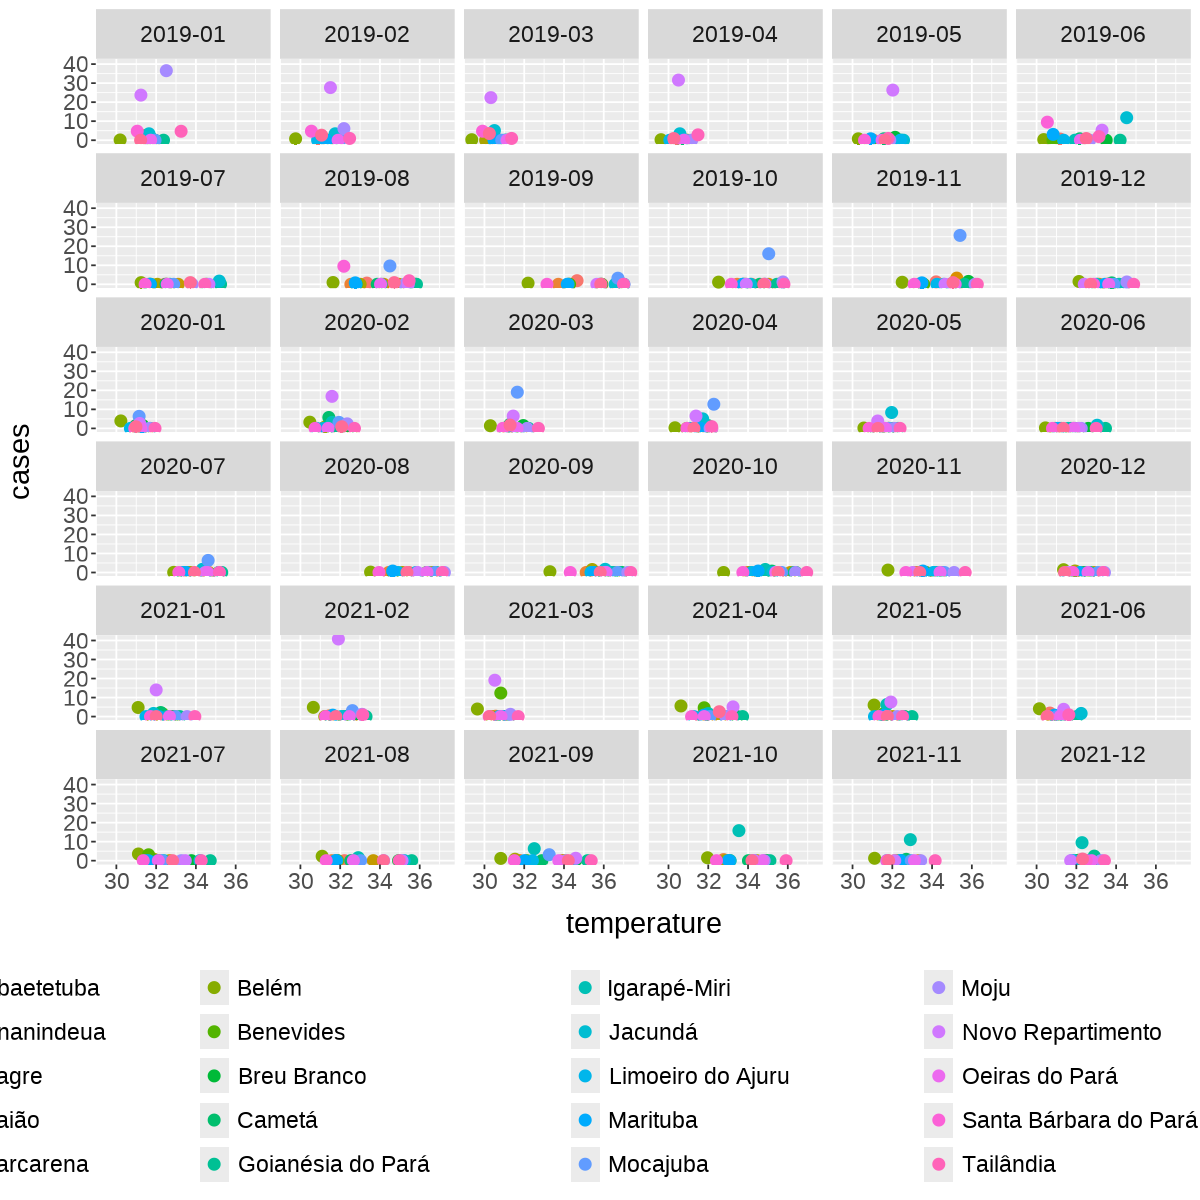

In [132]:
options(repr.plot.width = 10, repr.plot.height = 10)

ggplot(merge_dengue_temperature) + 
geom_point(aes(x=temperature, y=cases, colour=nm_mun), size=3) + 
facet_wrap(year_month ~ .) + 
theme(
    legend.position = "bottom",
    text = element_text(size=22)
)

## 4.2 NDVI vs. Dengue